In [110]:
from typing import Sequence, Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cirq

In [111]:
def gamma_layer(gamma: float, qubit_graph: nx.Graph) -> cirq.Circuit:
    gamma_ckt = cirq.Circuit()
    for q1, q2 in qubit_graph.edges:
        gamma_ckt.append(cirq.ZZ(q1, q2) ** gamma)
    return gamma_ckt

In [112]:
def beta_layer(beta: float, qubit_graph: nx.Graph) -> cirq.Circuit:
    beta_ckt = cirq.Circuit()
    for q in qubit_graph.nodes:
        beta_ckt.append(cirq.X(q) ** beta)
    return beta_ckt

In [113]:
def qaoa_circuit(gammas: np.ndarray, betas: np.ndarray, qubit_graph: nx.Graph) -> cirq.Circuit:
    """Make a circuit with the given QAOA parameters. The graph determines
    the connectivity of the Ansatz."""

    assert gammas.size == betas.size

    qaoa_ckt = cirq.Circuit()
    for q in qubit_graph.nodes:
        qaoa_ckt.append(cirq.H(q))
    for gamma, beta in zip(gammas, betas):
        qaoa_ckt += gamma_layer(gamma, qubit_graph)
        qaoa_ckt += beta_layer(beta, qubit_graph)
    return qaoa_ckt

In [114]:
def maxcut_hamiltonian(qubit_graph: nx.Graph) -> cirq.PauliSum:
    ham = cirq.PauliSum()
    for q1, q2 in qubit_graph.edges:
        ham += -1.0 * edge_operator(q1, q2)
    return ham

def edge_operator(q1: cirq.Qid, q2: cirq.Qid) -> cirq.PauliSum:
    """Eqn. 12 of QAOA paper."""

    return -0.5 * cirq.PauliString({q1: cirq.Z, q2: cirq.Z}) + 0.5 * cirq.PauliString()

In [115]:
def maxcut_energy(gammas: np.ndarray, betas: np.ndarray, qubit_graph: nx.Graph, observable: cirq.PauliSum) -> float:
    """Get the energy for specific variational parameters (gamma, beta) and 
    the given graph (determines both the Ansatz and the Hamiltonian connectivity)."""

    maxcut_observable = cirq.PauliSum()
    qaoa_ckt = qaoa_circuit(gammas, betas, qubit_graph)
    sim = cirq.Simulator()
    return sim.simulate_expectation_values(qaoa_ckt, [observable])[0].real

In [116]:
def energy_grad(gammas: np.ndarray, betas: np.ndarray, qubit_graph: nx.Graph, observable: cirq.PauliSum, eps: float=1e-5) -> Tuple[np.ndarray, np.ndarray]:
    """Get the gradient for the given values of gamma and beta. This uses a finite difference."""

    gamma_grad = np.zeros(gammas.size)
    for i in range(gammas.size):
        gamma_plus = gammas.copy()
        gamma_plus[i] += eps
        gamma_minus = gammas.copy()
        gamma_minus[i] -= eps
        plus_energy = maxcut_energy(gamma_plus, betas, qubit_graph, observable)
        minus_energy = maxcut_energy(gamma_minus, betas, qubit_graph, observable)
        gamma_grad[i] = (plus_energy - minus_energy) / (2.0 * eps)
    beta_grad = np.zeros(betas.size)
    for i in range(betas.size):
        beta_plus = betas.copy()
        beta_plus[i] += eps
        beta_minus = betas.copy()
        beta_minus[i] -= eps
        plus_energy = maxcut_energy(gammas, beta_plus, qubit_graph, observable)
        minus_energy = maxcut_energy(gammas, beta_minus, qubit_graph, observable)
        beta_grad[i] = (plus_energy - minus_energy) / (2.0 * eps)
    return gamma_grad, beta_grad

In [117]:
def grad_train(
    gamma0: np.ndarray, beta0: np.ndarray, qubit_graph: nx.Graph, 
    observable: cirq.PauliSum, steps: int, 
    eta: float=1e-4, eps: float=1e-5
) -> Tuple[List[float], np.ndarray, np.ndarray]:
    """Train the Ansatz by gradient descent at a rate eta."""

    assert gamma0.size == beta0.size

    gammas: np.ndarray = gamma0.copy()
    betas: np.ndarray = beta0.copy()
    energies: List[float] = []
    energies.append(maxcut_energy(gammas, betas, qubit_graph, observable))
    for _ in range(steps):
        energy = maxcut_energy(gammas, betas, qubit_graph, observable)
        energies.append(energy)
        gamma_grad, beta_grad = energy_grad(gammas, betas, qubit_graph, observable)
        gammas -= eta * gamma_grad
        betas -= eta * beta_grad
    return energies, gammas, betas

In [118]:
p = 2
qs = cirq.LineQubit.range(2 * p + 2)
qubit_graph = nx.Graph()
for i in range(len(qs) - 1):
    qubit_graph.add_edge(qs[i], qs[(i+1) % len(qs)])
#hamiltonian = maxcut_hamiltonian(qubit_graph)
observable = -1.0 * edge_operator(qs[p], qs[p+1])

gammas = np.random.rand(p)
betas = np.random.rand(p)

energies, gammas, betas = grad_train(gammas, betas, qubit_graph, observable, 10000, 1e-4, 1e-6)

Final energy= -0.7779649198055267


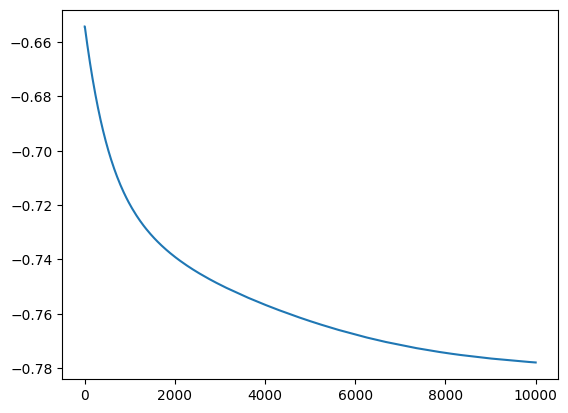

In [120]:
fig, ax = plt.subplots()
ax.plot(np.array(energies))
print(f"Final energy= {energies[-1]}")